# Bitext Retail Banking Chatbot Dataset — Exploratory Data Analysis (EDA)

Here we load the Bitext retail-banking LLM chatbot training dataset (from Hugging Face) and perform:
- Structural overview (rows/columns, dtypes, memory)
- Missing data and duplicates checks
- Distribution checks (labels/intents)
- Text profiling (lengths, most common tokens)
- A simple cleaning pipeline and “before vs after” comparison




In [ ]:
# Uncomment if needed:
# %pip install pandas pyarrow fsspec huggingface-hub scikit-learn matplotlib


## Imports
> Using your requested imports (and adding a couple of small utilities).


In [ ]:



import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## Load dataset from Hugging Face (Parquet)

This uses `pd.read_parquet()` with the `hf://` protocol. Ensure `pyarrow` + `fsspec` + `huggingface-hub` are installed.


In [ ]:
df = pd.read_parquet(
    "hf://datasets/bitext/Bitext-retail-banking-llm-chatbot-training-dataset/"
    "bitext-retail-banking-llm-chatbot-training-dataset.parquet"
)

df.head()


,tags,instruction,category,intent,response
0,BCIPZ,"I would like to acivate a card, can you help me?",CARD,activate_card,I'm here to assist you with that! Activating y...
1,BCILZ,"I have to activate an Visa online, how can I d...",CARD,activate_card,I'm here to assist you with activating your {{...
2,BCIPQZ,I'd like to actiate a card where do i do it,CARD,activate_card,I can help you with that! Activating your card...
3,BCLPQZ,I'd likke to activate a visa on mobile i need ...,CARD,activate_card,I'm here to assist you with activating your {{...
4,BCILPZ,"I would ilke to activate a credit card online,...",CARD,activate_card,I'm here to assist you with activating your cr...


## Dataset overview


In [ ]:
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

display(df.sample(5, random_state=42))


Shape: (25545, 5)

Columns: ['tags', 'instruction', 'category', 'intent', 'response']


,tags,instruction,category,intent,response
6628,BCPZ,"I would like to cancel a loan , help me",LOAN,cancel_loan,I'm sorry to hear that you're looking to cance...
20099,BCLPZ,"I'd like tl find a branch near me, I need help",FIND,find_branch,I'm here to assist you in finding a branch nea...
11548,BCIZ,"I need information about my account fees, how ...",FEES,check_fees,Definitely! I'm here to assist you in finding ...
24434,BILQZ,can uhelp me to recover an master card,ATM,recover_swallowed_card,I'm here to help you recover your MasterCard. ...
16791,BIPZ,could I regidter?,ACCOUNT,create_account,I'll do my best! I'm here to assist you in cre...


In [ ]:
# dtypes + memory
overview = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "nulls": df.isna().sum(),
    "null_%": (df.isna().mean() * 100).round(2),
})
# approximate memory footprint
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Approx memory usage: {mem_mb:.2f} MB")

overview.sort_values(["nulls", "non_null"], ascending=[False, False]).head(30)


Approx memory usage: 30.06 MB


,dtype,non_null,nulls,null_%
tags,object,25545,0,0.0
instruction,object,25545,0,0.0
category,object,25545,0,0.0
intent,object,25545,0,0.0
response,object,25545,0,0.0


## Missing values

Here we check for:
- Total missing cells
- Column-wise missingness
- A quick bar plot to spot problematic columns if present


In [ ]:
total_cells = df.shape[0] * df.shape[1]
missing_cells = int(df.isna().sum().sum())
print(f"Missing cells: {missing_cells:,} / {total_cells:,} ({missing_cells/total_cells*100:.4f}%)")

missing_by_col = df.isna().mean().sort_values(ascending=False) * 100
missing_by_col = missing_by_col[missing_by_col > 0]
missing_by_col


Missing cells: 0 / 127,725 (0.0000%)


Series([], dtype: float64)

In [ ]:
if len(missing_by_col) == 0:
    print("✅ No missing values found across all columns.")
else:
    plt.figure(figsize=(10, 4))
    plt.bar(missing_by_col.index.astype(str), missing_by_col.values)
    plt.xticks(rotation=75, ha="right")
    plt.ylabel("Missing (%)")
    plt.title("Missingness by column")
    plt.tight_layout()
    plt.show()


✅ No missing values found across all columns.


## Duplicates

We check:
- Fully duplicated rows
- Duplicates on likely “key text fields” (if present)

Because column names can differ across datasets, we detect text-like columns automatically.


In [ ]:
# Full row duplicates
dup_rows = df.duplicated().sum()
print("Fully duplicated rows:", int(dup_rows))

# Heuristic: treat object columns as possible text columns
text_cols = [c for c in df.columns if df[c].dtype == "object"]
print("\nText-like columns:", text_cols)

# If there are at least 2 text columns, check duplicates on all text columns together
if len(text_cols) >= 2:
    dup_on_text = df.duplicated(subset=text_cols).sum()
    print("Duplicated rows based on ALL text-like columns:", int(dup_on_text))
else:
    print("Not enough text-like columns to run a subgroup duplicate test.")


Fully duplicated rows: 0

Text-like columns: ['tags', 'instruction', 'category', 'intent', 'response']
Duplicated rows based on ALL text-like columns: 0


## Label / intent distribution

Most chatbot datasets have a label-like column (e.g., `intent`, `label`, `category`, etc.).
We’ll:
1) Try to auto-detect a likely label column
2) Plot the top categories if found


In [ ]:
# Auto-detect a label column by common names or by low-ish cardinality among object columns
common_label_names = ["intent", "label", "category", "class", "tag", "scenario", "domain"]

label_col = None
for name in common_label_names:
    if name in df.columns:
        label_col = name
        break

if label_col is None:
    # fallback heuristic: pick an object column with not-too-high cardinality
    candidates = []
    for c in text_cols:
        nunique = df[c].nunique(dropna=True)
        if 2 <= nunique <= min(200, max(10, int(df.shape[0] * 0.05))):
            candidates.append((c, nunique))
    candidates.sort(key=lambda x: x[1])  # prefer lower cardinality
    label_col = candidates[0][0] if candidates else None

print("Detected label column:", label_col)


Detected label column: intent


intent
activate_card                        1000
find_branch                          1000
check_recent_transactions             999
human_agent                           999
close_account                         999
customer_service                      998
find_ATM                              998
block_card                            998
activate_card_international_usage     997
apply_for_mortgage                    997
make_transfer                         997
cancel_card                           996
cancel_mortgage                       996
check_card_annual_fee                 996
create_account                        996
cancel_transfer                       995
recover_swallowed_card                994
check_current_balance_on_card         993
apply_for_loan                        992
cancel_loan                           990
Name: count, dtype: int64

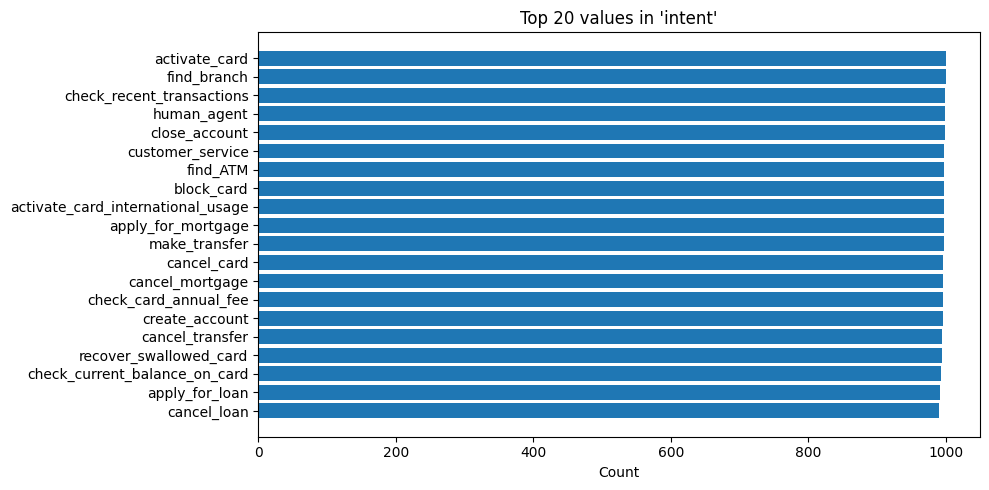

In [ ]:
if label_col is None:
    print("⚠️ Could not confidently detect a label/intent column. Check df.columns and set label_col manually.")
else:
    vc = df[label_col].value_counts(dropna=False)
    display(vc.head(20))

    topn = 20 if len(vc) > 20 else len(vc)
    plt.figure(figsize=(10, 5))
    plt.barh(vc.head(topn).index.astype(str)[::-1], vc.head(topn).values[::-1])
    plt.title(f"Top {topn} values in '{label_col}'")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()


## Text columns + length profiling

Here we:
- Auto-detect a main **user utterance** column and (if exists) a **bot response** column
- Compute character length and word count
- Visualize distributions

If auto-detection fails, just manually set `user_col` / `bot_col`.


In [ ]:
# Heuristics for common names
user_candidates = ["instruction", "utterance", "user", "query", "text", "input", "question"]
bot_candidates  = ["response", "answer", "assistant", "output", "reply"]

user_col = next((c for c in user_candidates if c in df.columns), None)
bot_col  = next((c for c in bot_candidates if c in df.columns), None)

# fallback: pick two longest-average object columns (often user/bot text)
if user_col is None and len(text_cols) > 0:
    avg_len = [(c, df[c].astype(str).str.len().mean()) for c in text_cols]
    avg_len.sort(key=lambda x: x[1], reverse=True)
    user_col = avg_len[0][0]

if bot_col is None and len(text_cols) > 1:
    avg_len = [(c, df[c].astype(str).str.len().mean()) for c in text_cols if c != user_col]
    avg_len.sort(key=lambda x: x[1], reverse=True)
    bot_col = avg_len[0][0] if avg_len else None

print("Detected user_col:", user_col)
print("Detected bot_col :", bot_col)


Detected user_col: instruction
Detected bot_col : response


In [ ]:
def add_text_stats(df_in, col, prefix):
    s = df_in[col].astype(str)
    df_in[prefix + "_char_len"] = s.str.len()
    df_in[prefix + "_word_count"] = s.str.split().map(len)
    return df_in

df_stats = df.copy()

if user_col is not None:
    df_stats = add_text_stats(df_stats, user_col, "user")
if bot_col is not None and bot_col != user_col:
    df_stats = add_text_stats(df_stats, bot_col, "bot")

df_stats[[c for c in df_stats.columns if c.endswith(("char_len","word_count"))]].describe().T


,count,mean,std,min,25%,50%,75%,max
user_char_len,25545.0,52.366334,14.978346,12.0,43.0,50.0,60.0,120.0
user_word_count,25545.0,11.129967,2.734339,2.0,9.0,11.0,13.0,23.0
bot_char_len,25545.0,909.765277,382.208272,80.0,650.0,861.0,1096.0,2808.0
bot_word_count,25545.0,152.419338,59.223744,14.0,112.0,146.0,184.0,430.0


1) User messages are short and consistent

Average user length: ~52 chars and 11 words

Middle 50% of users (IQR):

chars: 43 → 60

words: 9 → 13

Range: 2 to 23 words, 12 to 120 chars

Interpretation: users ask short, fairly uniform queries (typical for intent classification datasets).

2) Bot responses are much longer and more variable

Average bot length: ~910 chars and 152 words

Middle 50% (IQR):

chars: 650 → 1096

words: 112 → 184

Maximum: 2808 chars / 430 words (some responses are very long)

Interpretation: bot answers often include multi-sentence explanations, steps, disclaimers, or extra info, and some responses are “essay-like.”

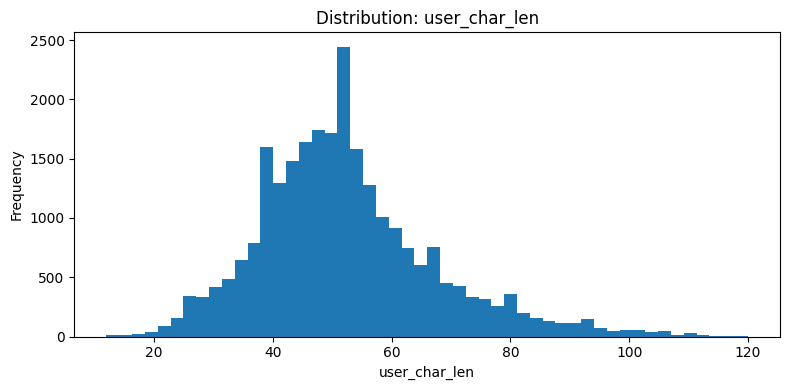

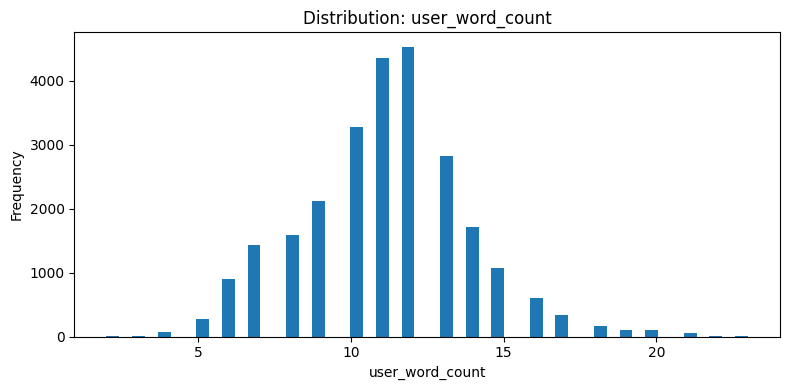

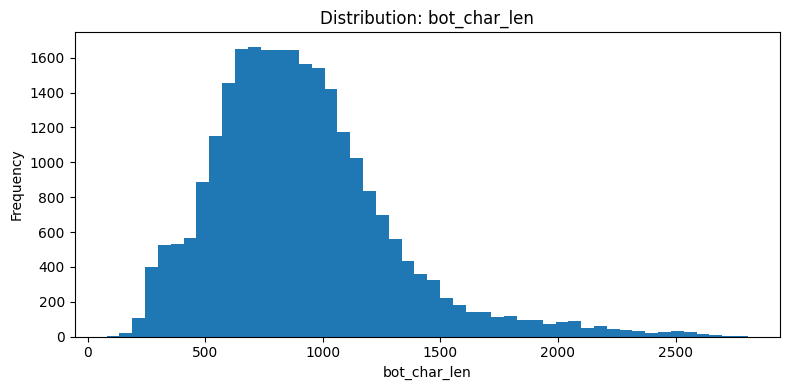

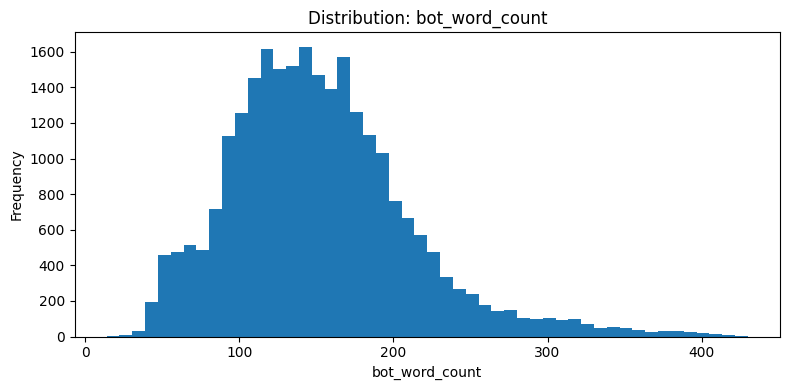

In [ ]:
# Histograms (matplotlib)
num_cols = [c for c in df_stats.columns if c.endswith(("char_len", "word_count"))]
if len(num_cols) == 0:
    print("No derived length columns found.")
else:
    for c in num_cols:
        plt.figure(figsize=(8, 4))
        plt.hist(df_stats[c].dropna().values, bins=50)
        plt.title(f"Distribution: {c}")
        plt.xlabel(c)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


1) Most user messages cluster around ~40–60 characters
The tallest bars (the peak) are roughly in that range, meaning that’s the typical user query length in this dataset.

It’s slightly right-skewed (long tail to the right)
You have fewer and fewer messages as lengths increase beyond ~60, but there are still some longer queries stretching out to ~120 characters.

Very short messages are rare
There are some messages around ~10–20 characters, but the bars are tiny there—so short “hi”, “help”, etc. aren’t common.


2) Most messages are about 10–13 words long
The tallest bars are around 11–12 words, which matches your summary stats (mean ≈ 11.13, median = 11).

It’s concentrated 
Its not very spread out. A big chunk of the dataset sits in a narrow band (roughly 8–15 words). That means user queries are fairly uniform in length.

There’s a small right tail (longer messages are rare)
You still have some messages up to about 20–23 words, but the bars get much smaller as word count increases.

Very short messages exist but are uncommon
Counts below ~5 words are present, but they’re a tiny fraction.

3) Most bot responses are long (roughly ~600 to ~1100 characters)
The highest bars are around that region, meaning that’s the “typical” response length. This matches your stats (median ≈ 861, mean ≈ 910).

Right-skewed with a long tail 
The bot gives some very long responses. After ~1100–1500 characters the frequency drops off, but the distribution stretches out to ~2800 characters. Those are the unusually long, detailed answers.

Few very short bot responses
The left side (under a few hundred characters) has small frequencies, so most responses aren’t short one-liners.

## Token frequency (simple)

A quick look at the most common tokens in the user text can reveal:
- Lots of templating artifacts
- Excessive punctuation/noise
- Whether lowercasing / normalization may help

We’ll keep this light: basic cleaning + top tokens using `CountVectorizer`.


In [ ]:
def basic_normalize(text: str) -> str:
    text = str(text)
    text = text.lower().strip()
    text = re.sub(r"\s+", " ", text)
    return text

if user_col is None:
    print("⚠️ No user_col detected; set user_col manually to run token frequency.")
else:
    sample_text = df[user_col].astype(str).map(basic_normalize)
    vec = CountVectorizer(stop_words="english", max_features=30)
    X = vec.fit_transform(sample_text)
    vocab = np.array(vec.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    top = pd.DataFrame({"token": vocab, "count": freqs}).sort_values("count", ascending=False)
    top


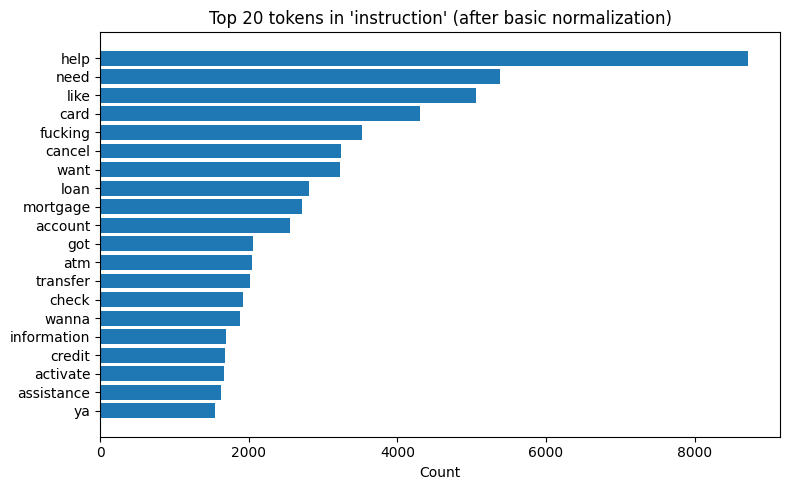

In [ ]:
# Plot top tokens
if user_col is not None:
    topn = 20
    top_plot = top.head(topn)[::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(top_plot["token"], top_plot["count"])
    plt.title(f"Top {topn} tokens in '{user_col}' (after basic normalization)")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()


## Cleaning pipeline

Typical cleaning for chatbot datasets:
- Remove fully duplicated rows
- Strip whitespace in text fields
- Drop rows where the main user text is empty after stripping
- (Optional) Normalize whitespace / casing in derived text columns used for modeling

We’ll create:
- `df_raw` (original)
- `df_clean` (cleaned)

Then compare row counts and duplicates removed.


In [ ]:
df_raw = df.copy()

def clean_text_series(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s

df_clean = df_raw.copy()

# 1) remove full-row duplicates
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print("Removed full-row duplicates:", before - len(df_clean))

# 2) clean detected text columns
for c in text_cols:
    df_clean[c] = clean_text_series(df_clean[c])

# 3) remove empty user text rows (if we have a user_col)
if user_col is not None:
    before = len(df_clean)
    df_clean = df_clean[df_clean[user_col].str.len() > 0].copy()
    print("Removed empty user-text rows:", before - len(df_clean))

print("\nRaw rows  :", len(df_raw))
print("Clean rows:", len(df_clean))


Removed full-row duplicates: 0
Removed empty user-text rows: 0

Raw rows  : 25545
Clean rows: 25545


## Before vs After summary


In [ ]:
summary = pd.DataFrame({
    "rows": [len(df_raw), len(df_clean)],
    "cols": [df_raw.shape[1], df_clean.shape[1]],
    "missing_cells": [int(df_raw.isna().sum().sum()), int(df_clean.isna().sum().sum())],
    "dup_rows_full": [int(df_raw.duplicated().sum()), int(df_clean.duplicated().sum())],
}, index=["raw", "clean"])
summary


,rows,cols,missing_cells,dup_rows_full
raw,25545,5,0,0
clean,25545,5,0,0
